<a href="https://colab.research.google.com/github/nehanawar025/Cyberbulling_text_classification_using_NLP/blob/main/CyberBullying(BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizerFast

In [47]:
df = pd.read_csv('admin.csv')
df.head()

,id,text,label,Comments
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,NaN
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,normal,NaN
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,NaN
3,7792,"Finally I'm all caught up, and that sudden dea...",normal,NaN
4,7793,@carolinesinders @herecomesfran *hugs*,normal,NaN


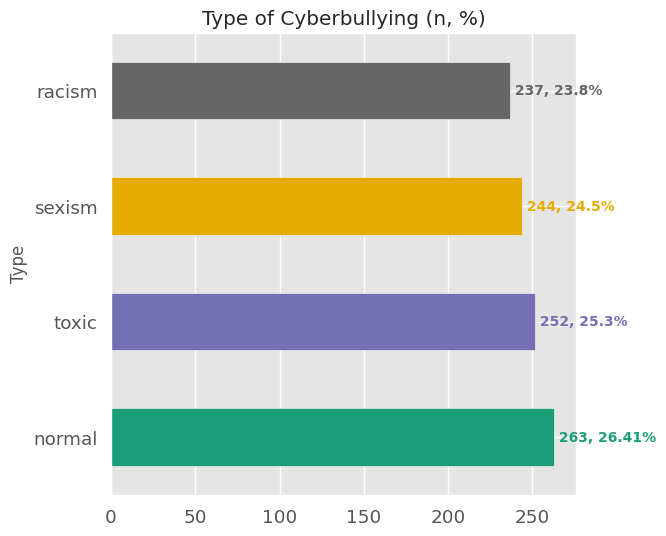

In [48]:

plt.style.use('ggplot')

num_classes = len(df["label"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['label'].value_counts().plot.barh(title="Type of Cyberbullying (n, %)",
                                                 ylabel="Type",
                                                 color=colors,
                                                 figsize=(6,6))

for i, v in enumerate(df['label'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%",
           color=c,
           va='center',
           fontweight='bold')

In [25]:
df['Types'] = df['label'].map({'racism': 0,
                                            'sexism': 1,
                                            'toxic': 2,
                                            'normal': 3
                                            })

# drop unused column
df = df.drop(["label"], axis=1)

df.head()


,id,text,Comments,Types
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,NaN,0
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,NaN,3
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,NaN,0
3,7792,"Finally I'm all caught up, and that sudden dea...",NaN,3
4,7793,@carolinesinders @herecomesfran *hugs*,NaN,3


In [29]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
df['Text'] = df['text'].apply(preprocess_text)
df.head()

,id,text,Comments,Types,Text
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,NaN,0,aalwuhaib1977 muslim mob violence hindus bangl...
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,NaN,3,te4m nightm4re http co 5ih7mkdbqg
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,NaN,0,jncatron isra jourisra ampalestine islamophobi...
3,7792,"Finally I'm all caught up, and that sudden dea...",NaN,3,finally caught sudden death cook looks like go...
4,7793,@carolinesinders @herecomesfran *hugs*,NaN,3,carolinesinders herecomesfran hugs


In [11]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [31]:
y = tf.keras.utils.to_categorical(df["Types"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['Text'], y, test_size=0.20)

In [ ]:
!pip install tensorflow-text

In [32]:
import tensorflow_hub as hub
import tensorflow_text as text


In [33]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_encoder_model = hub.KerasLayer(encoder_url)

In [ ]:
def get_embeddings(sentences):
    preprocessed_text = bert_preprocess_model(sentences)
    return bert_encoder_model(preprocessed_text)['pooled_output']

embeddings = get_embeddings([
    "Muslim mob violence against Hindus in Bangladesh continues in 2014."
    "Does N.e.bodyelse Hear her Crazy ass Screamin ,HOE, everytime she say's Stupid Hoe .. Lol. did n.e.body see Chris Browns face at 2:04 wen Nicki was touchin him If"
    "=stop ur stupid invlovment===="
    "We still do, as well as underestimating the judging #MKR"

])

print(embeddings)

In [35]:

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues",
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

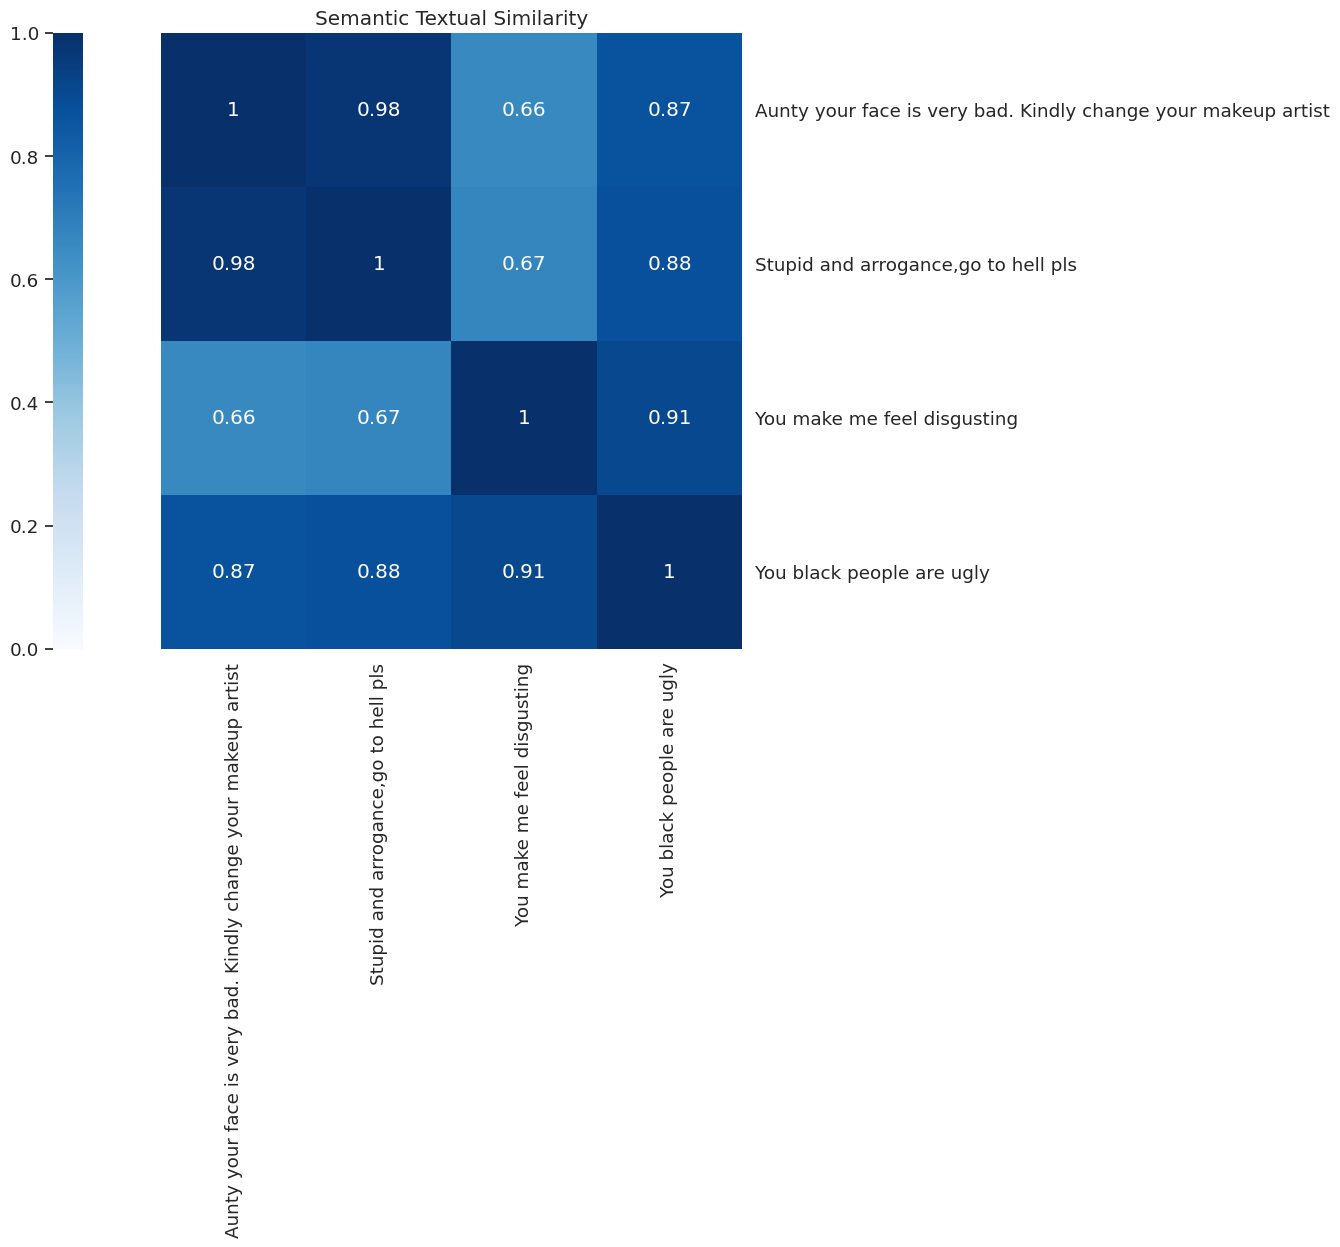

In [36]:
cmnts = [
    'Aunty your face is very bad. Kindly change your makeup artist',
    'Stupid and arrogance,go to hell pls',
    'You make me feel disgusting',
    'You black people are ugly'

]
plot_similarity(get_embeddings(cmnts), cmnts)

In [37]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):

    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):

    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [50]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = bert_preprocess_model(i)
x = bert_encoder_model(x)
x = tf.keras.layers.Dropout(0.5, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [58]:
n_epochs = 50

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test))
                      #callbacks = [earlystop_callback])

Epoch 1/50
25/25 [==============================] - 15s 482ms/step - loss: 0.9922 - accuracy: 0.5842 - balanced_recall: 0.3637 - balanced_precision: 0.6624 - balanced_f1_score: 0.4666 - val_loss: 1.0099 - val_accuracy: 0.6150 - val_balanced_recall: 0.3400 - val_balanced_precision: 0.5722 - val_balanced_f1_score: 0.4161
Epoch 2/50
25/25 [==============================] - 11s 433ms/step - loss: 1.0128 - accuracy: 0.5628 - balanced_recall: 0.3665 - balanced_precision: 0.6040 - balanced_f1_score: 0.4501 - val_loss: 1.0126 - val_accuracy: 0.5700 - val_balanced_recall: 0.3605 - val_balanced_precision: 0.6397 - val_balanced_f1_score: 0.4445
Epoch 3/50
25/25 [==============================] - 10s 414ms/step - loss: 1.0270 - accuracy: 0.5302 - balanced_recall: 0.3736 - balanced_precision: 0.6306 - balanced_f1_score: 0.4674 - val_loss: 1.0070 - val_accuracy: 0.6000 - val_balanced_recall: 0.3253 - val_balanced_precision: 0.6970 - val_balanced_f1_score: 0.4213
Epoch 4/50
25/25 [===================

In [59]:
evaluation_results = model.evaluate(x_train, y_train)
total_accuracy = evaluation_results[model.metrics_names.index('accuracy')]

print(f'Total Accuracy: {total_accuracy * 100:.2f}%')


25/25 [==============================] - 8s 330ms/step - loss: 0.8159 - accuracy: 0.6960 - balanced_recall: 0.4834 - balanced_precision: 0.8195 - balanced_f1_score: 0.6049
Total Accuracy: 69.60%


In [60]:
evaluation_results = model.evaluate(x_test, y_test)
total_accuracy = evaluation_results[model.metrics_names.index('accuracy')]

print(f'Total Accuracy: {total_accuracy * 100:.2f}%')


7/7 [==============================] - 2s 300ms/step - loss: 0.9450 - accuracy: 0.6500 - balanced_recall: 0.4393 - balanced_precision: 0.7500 - balanced_f1_score: 0.5449
Total Accuracy: 65.00%


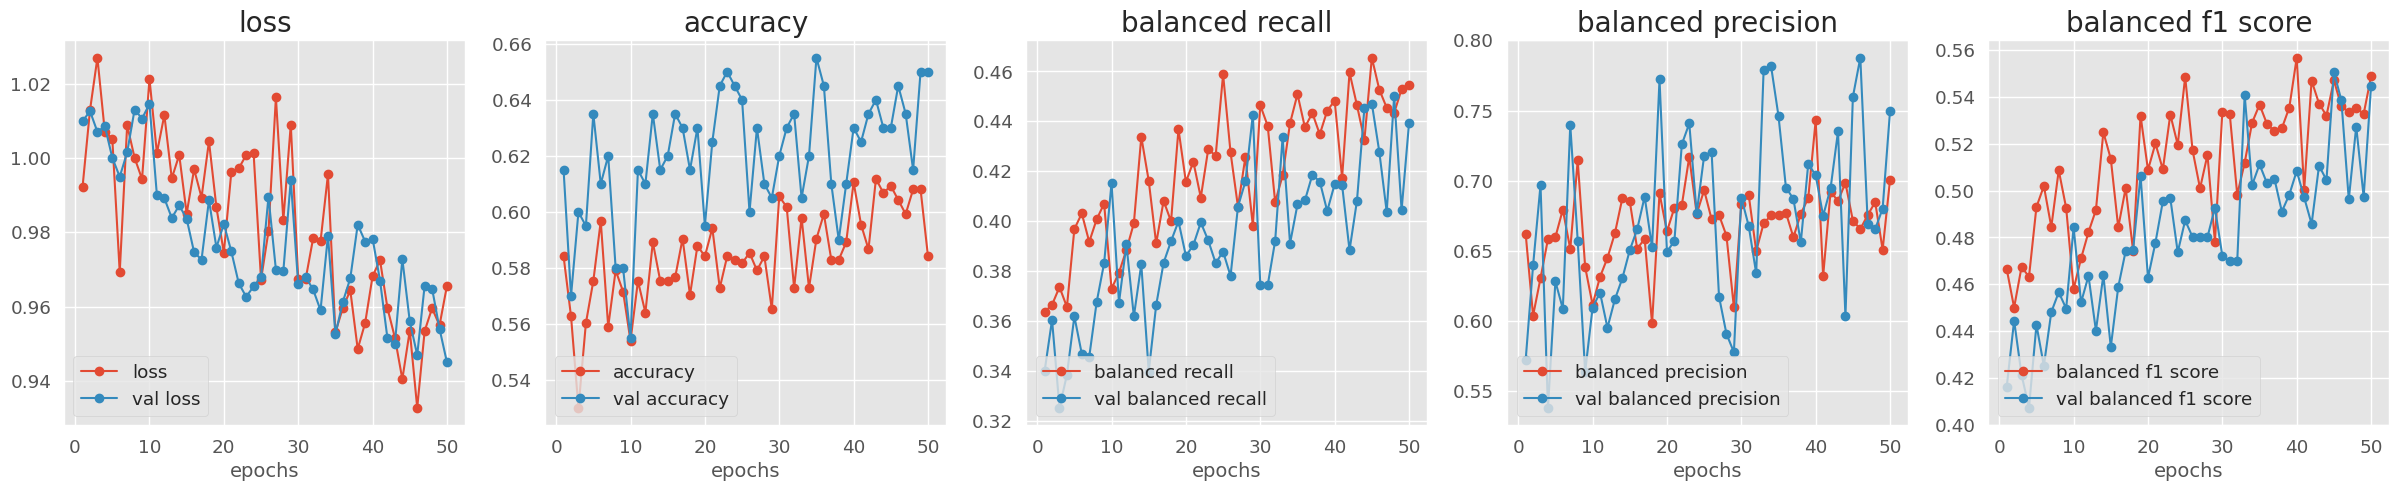

In [61]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [62]:
comments = [
    "You make me feel disgusting",
    "She is so ugly. I don't like her face",
    "Go kill yourself.",
    "You are pretty"

]


In [63]:
def predict_class(comments):
    predicted_probabilities = model.predict(comments)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    return predicted_classes


predicted_classes = predict_class(comments)
print(predicted_classes)

1/1 [==============================] - 1s 759ms/step
[3 1 3 3]


In [64]:
y_predicted_probabilities = model.predict(x_test)
y_predicted_classes = np.argmax(y_predicted_probabilities, axis=1)

7/7 [==============================] - 3s 317ms/step


In [65]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_test, axis=1), y_predicted_classes)
classification_rep = classification_report(np.argmax(y_test, axis=1), y_predicted_classes)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[37  4  5  1]
 [ 4 26  4 14]
 [ 1  5 32 11]
 [10  7  4 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        47
           1       0.62      0.54      0.58        48
           2       0.71      0.65      0.68        49
           3       0.57      0.62      0.60        56

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200



Text(43.25, 0.5, 'Truth')

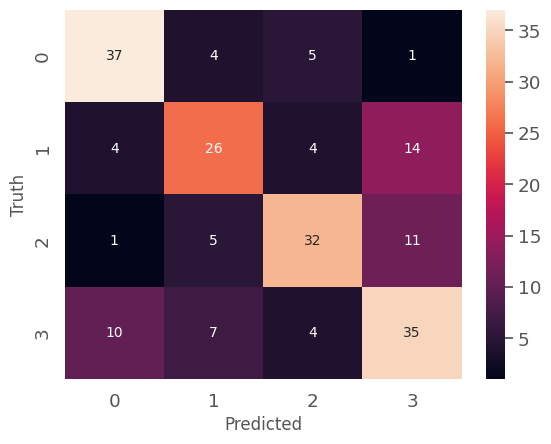

In [66]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')